# figs_twitter.ipynb

Author: MB

Date run: April 1, 2021

Location: HPC

The purpose of this script is to read in a dataset of retweets of Trump tweets and generate three figures
* the cumulative number of retweets over time
* average number of followers per retweet by engagement type
* average number of engagements per retweet by engagement type

Data in: 
* Decahose (filtered to just retweets of Trump tweets) -- 10% of all tweets
* Dataset of interventions to tweets
* labels for Trump tweets

Data out: the aforementioned figures

In [1]:
# imports 
import datetime
import glob
import json
import os
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def fill_frame(frame, tweet_id):
    '''
    this function forward fills metrics to fill in missing minutes where there is not a record of the number of retweets
    it then returns the filled dataframe
    
    :pd.DataFrame frame: a dataframe of tweets with the number of seconds since posting `seconds` and number of retweets at that timestamp `count`
    '''
    # sort dataframe in ascending order by seconds
    frame = frame.sort_values('seconds')
    
    # append the missing seconds to the dataframe with an empty count value
    seconds_we_have = frame['seconds'].unique()
    frame = frame.append([{'seconds':i} for i in range(0, 86401) if i not in seconds_we_have]).sort_values('seconds')
    
    # forward fill the dataframe (carry values up to the next non-null value)
    frame['og_retweet_count'] = frame['og_retweet_count'].fillna(method='ffill')
    frame['tweet_id'] = tweet_id
    
    return frame

def convert_datetime(time):
    '''
    converts twitter timestamp string into a datetime object
    
    :str time: the twitter-style timestamp for tweet creation
    :returns date: a datetime.datetime object corresponding to the time input
    '''
    if isinstance(time, str):
        return datetime.datetime.strptime(time, '%a %b %d %H:%M:%S +0000 %Y')

In [3]:
# set colors
no_intervention_color = '#16697a'
soft_intervention_color = '#ffa62b'
hard_intervention_color = '#721121'

In [4]:
# read in the intervention dataset
interventions = pd.read_json('../data/interventions.json', orient='records', lines=True, dtype={'id_str':str})

In [5]:
# read in the labels and unique trump tweets 
labels = pd.read_csv('../data/labels.csv')
trump_tweets = pd.read_csv('../data/trump_tweets.csv', dtype={'retweeted__id':str})

In [6]:
# copy `Final` data to `political` because I like that better
trump_tweets['political'] = labels['Final']

In [7]:
# filter Trump tweets only to tweets labelled as political
political_tweets = trump_tweets[trump_tweets['political'] == 'political']['retweeted__id'].tolist()

In [8]:
# filter interventions to Trump tweets that are political
interventions = interventions[interventions['id_str'].isin(political_tweets)].drop_duplicates('id_str').copy()

In [9]:
# get tweet IDs by intervention type
no_intervention = interventions[(interventions['hard_intervention'] == False) & (interventions['soft_intervention'] == False)]['id_str'].tolist()
soft_intervention = interventions[(interventions['hard_intervention'] == False) & (interventions['soft_intervention'] == True)]['id_str'].tolist()
hard_intervention = interventions[(interventions['hard_intervention'] == True)]['id_str'].tolist()

# Retweet Data 

In [10]:
# load retweet data
retweets = pd.read_json('../data/twitter_posts.json.bz2', orient='records', lines=True, compression='bz2',
                        dtype={'tweet_id':str, 'og_tweet_id':str})

In [11]:
# filter by tweets that happened within 24 hours of the tweet being published
retweets = retweets[(retweets['created_at'] - retweets['og_created_at'] > datetime.timedelta(minutes=0))
                    & (retweets['created_at'] - retweets['og_created_at'] <= datetime.timedelta(hours=24))
             ].copy()

In [12]:
# calculate time diff between retweet and og tweet
retweets['time_diff'] = (retweets['created_at'] - retweets['og_created_at']).values / np.timedelta64(1, 's')

In [13]:
# calculate hours, minutes and seconds
retweets['seconds'] = retweets['time_diff']
retweets['minutes'] = retweets['seconds'] / 60
retweets['hours'] = retweets['minutes'] / 60

In [14]:
# filter to political tweets 
retweets = retweets[retweets['og_tweet_id'].isin(political_tweets)].copy()

In [15]:
# forward fill dataframes for missing seconds 
filled_frames = pd.concat([fill_frame(frame, _) for _, frame in retweets.groupby('og_tweet_id')])

In [16]:
# group by intervention type
hard = filled_frames[filled_frames['tweet_id'].isin(hard_intervention)].copy()
soft = filled_frames[filled_frames['tweet_id'].isin(soft_intervention)].copy()
none = filled_frames[filled_frames['tweet_id'].isin(no_intervention)].copy()

In [18]:
# calculate cumulative rolling average for each intervention type
hard_plot = hard.groupby('seconds')['og_retweet_count'].mean().rolling(window=3600, min_periods=20).mean()
soft_plot = soft.groupby('seconds')['og_retweet_count'].mean().rolling(window=3600, min_periods=20).mean()
none_plot = none.groupby('seconds')['og_retweet_count'].mean().rolling(window=3600, min_periods=20).mean()

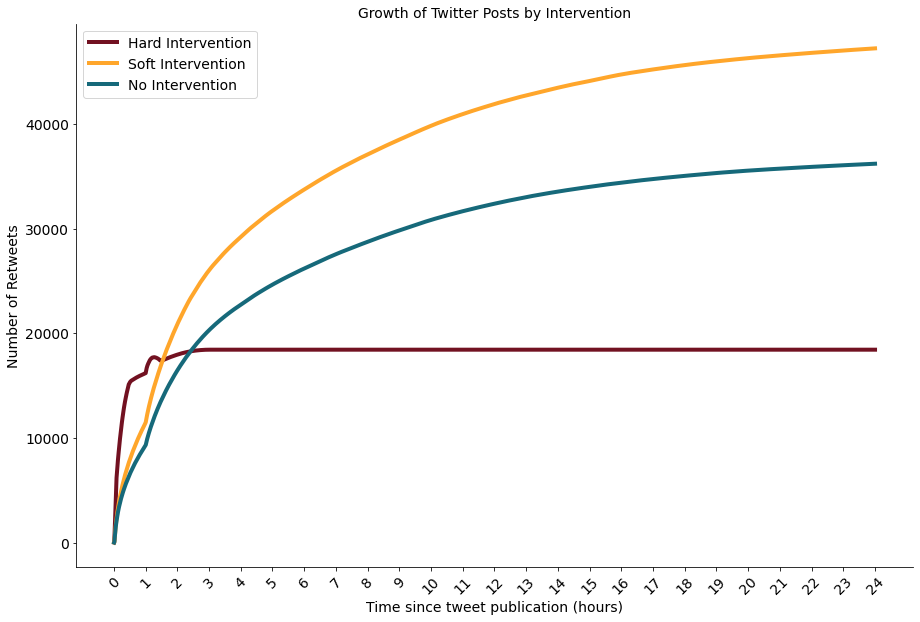

In [24]:
# plot cumulative retweet rolling averages
plt.figure(figsize=(15,10))
plt.plot(hard_plot, label='Hard Intervention', color=hard_intervention_color, linewidth=4)
plt.plot(soft_plot, label='Soft Intervention', color=soft_intervention_color, linewidth=4)
plt.plot(none_plot, label='No Intervention', color=no_intervention_color, linewidth=4)

plt.legend(fontsize=14)
locs = [i*3600 for i in range(25)]
plt.xticks(locs, range(25), rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlabel('Time since tweet publication (hours)', fontsize=14)
plt.ylabel('Number of Retweets', fontsize=14)
plt.title('Growth of Twitter Posts by Intervention', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../plots/twitter_spread_of_tweets.png', dpi=600)

In [20]:
# split tweets into different intervention types
hard_ct = retweets[retweets['og_tweet_id'].isin(hard_intervention)].copy()
soft_ct = retweets[retweets['og_tweet_id'].isin(soft_intervention)].copy()
none_ct = retweets[retweets['og_tweet_id'].isin(no_intervention)].copy()

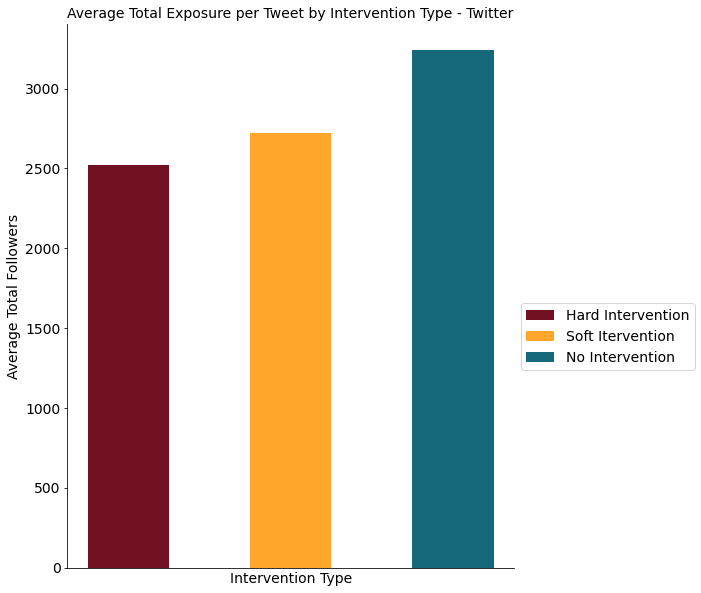

In [21]:
# plot average number of followers by intervention type
plt.figure(figsize=(8, 10))

plt.bar(0, width=.5, height=hard_ct.groupby('tweet_id')['user__followers_count'].sum().mean(), color=hard_intervention_color, label='Hard Intervention')
plt.bar(1, width=.5, height=soft_ct.groupby('tweet_id')['user__followers_count'].sum().mean(), color=soft_intervention_color, label='Soft Itervention')
plt.bar(2, width=.5, height=none_ct.groupby('tweet_id')['user__followers_count'].sum().mean(), color=no_intervention_color, label='No Intervention')
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks(fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor = [1, .5])
plt.xlabel('Intervention Type', fontsize=14)
plt.ylabel('Average Total Followers', fontsize=14)
plt.title('Average Total Exposure per Tweet by Intervention Type - Twitter', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../plots/twitter_avg_exposure.png', dpi=600)

In [22]:
# calculate the average number of favorites by intervention type
hard_interactions = hard_ct.groupby('og_tweet_id')['og_favorite_count'].max().mean()
soft_interactions = soft_ct.groupby('og_tweet_id')['og_favorite_count'].max().mean()
none_interactions = none_ct.groupby('og_tweet_id')['og_favorite_count'].max().mean()

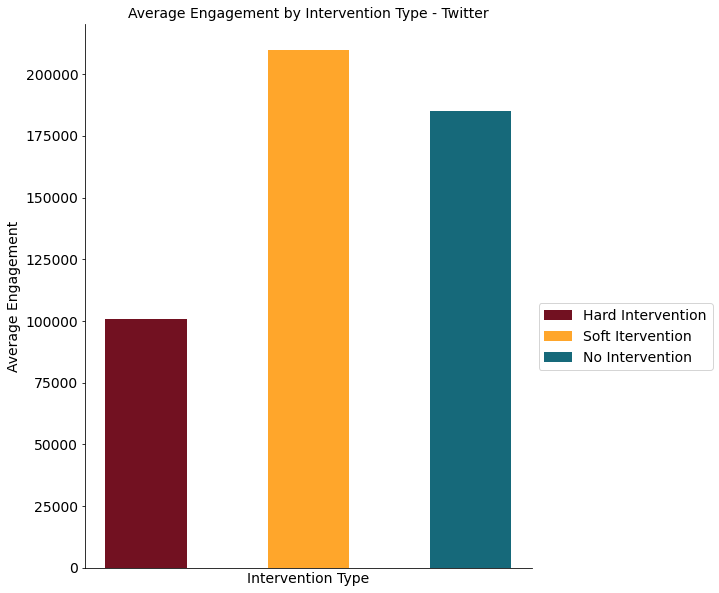

In [23]:
# plot the average number of engagements by intervention type
plt.figure(figsize=(8, 10))

plt.bar(0, width=.5, height=hard_interactions, color=hard_intervention_color, label='Hard Intervention')
plt.bar(1, width=.5, height=soft_interactions, color=soft_intervention_color, label='Soft Itervention')
plt.bar(2, width=.5, height=none_interactions, color=no_intervention_color, label='No Intervention')
plt.legend(fontsize=14)
plt.xticks([])
plt.yticks(fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor = [1, .5])
plt.xlabel('Intervention Type', fontsize=14)
plt.ylabel('Average Engagement', fontsize=14)
plt.title('Average Engagement by Intervention Type - Twitter', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../plots/twitter_avg_engagement.png', dpi=600)